# Предобработка

In [1]:
!pip install lightfm

     |████████████████████████████████| 310 kB 20.1 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705375 sha256=e505d9a2b1dadc70df8c3e70384fc67a6ce238da8adcdd1caa9c6b2c3a120a9c
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [2]:
!pip install implicit==0.4.4

     |████████████████████████████████| 1.1 MB 9.2 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3423196 sha256=059eeb183b0fc091f9e8e4c9af1176851559139939f787cca35529857e384282
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [3]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.8 MB/s 


### Import libs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix
# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM

# Модель второго уровня
from catboost import CatBoost

import os, sys

module_path = ['/content/drive/Othercomputers/Мое устройство Компьютер/Google.Disk/Colab Notebooks']
module_path.append(os.path.abspath(os.path.join(os.pardir)))
if module_path not in sys.path:
    sys.path.append(module_path[0])
    sys.path.append(module_path[1])

import warnings
warnings.filterwarnings('ignore')


In [5]:
# Написанные нами функции
from src.metrics import (precision_at_k, recall_at_k, \
                        show_proba_calibration_plots, evaluate_preds,\
                        evalPrecision, evalRecall, calc_precision, calc_get_own, \
                        rerank, print_stats_data)
from src.utils import prefilter_items
from src.recommenders import MainRecommenderALS, MainRecommenderLightFM, DataPreprocessing

### Read data

In [6]:
data = pd.read_csv('./data/transaction_data.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

In [7]:
data.head(1)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0


### Process features dataset

In [8]:
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id', 'product_id': 'item_id'}, inplace=True)

user_features.columns = [col.lower() for col in user_features.columns]
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

### Split dataset for train, eval, test

In [9]:
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [10]:
# проверка на новых пользователей
len(set(data_val_ranker['user_id']) - set(df_join_train_matcher['user_id']))

0

### Prefilter items

In [11]:
n_items_before = df_join_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data=df_join_train_matcher, 
                                    #item_features=item_features,
                                    resent_weeks = 0,
                                    filter_frequency = False,
                                    filter_prices = False,
                                    popularity_invert = False,
                                    take_n_popular = 1500)

n_items_after = data_train_matcher['item_id'].nunique()
print(f'Decreased # items from {n_items_before} to {n_items_after}')

Decreased # items from 90386 to 1501


### Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2467414, 12) Users: 2500 Items: 1501

val_matcher
Shape: (173922, 12) Users: 2152 Items: 27680

train_ranker
Shape: (173922, 12) Users: 2152 Items: 27680

val_ranker
Shape: (110194, 12) Users: 1991 Items: 23048



# Модэль ALS

In [13]:
model_ALS = MainRecommenderALS(data_train_matcher, IIR=True, ALS=False)

  0%|          | 0/1501 [00:00<?, ?it/s]

In [14]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

result_eval_matcher = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [15]:
N_PREDICT = 50
TOP_PRECISION = 5 
eval_matcher = {'own_rec': model_ALS.get_own_recommendations}

evalPrecision(result_eval_matcher, eval_matcher, TOP_PRECISION, N_PREDICT)

,Name,Score
0,actual,1.000
1,own_rec,0.257


In [16]:
TOP_RECALL = 50
evalRecall(result_eval_matcher, eval_matcher, TOP_RECALL, N_PREDICT)

,Name,Score
0,actual,0.852
1,own_rec,0.134


# Модэль LightFM

In [17]:
data_train = data_train_matcher.copy()

In [18]:
model_LightFM = MainRecommenderLightFM(data_train=data_train, 
                                       user_features=user_features, 
                                       item_features=item_features, 
                                       k=5)

Epoch: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


In [19]:
# добавляем наш полученный скор в трейн датафрейм
data_train['score'] = model_LightFM.get_recommendations(data_train[['user_id','item_id']])

In [20]:
# создаем предикт датафрейм в формате списка това
model_LightFM_predict_result = data_train[['user_id','item_id','score']][data_train.item_id != 999999].\
                            drop_duplicates().sort_values(by=['user_id','score'], ascending=False).groupby('user_id')['item_id']. \
                            unique().reset_index()
model_LightFM_predict_result.rename(columns={'item_id': 'warp'}, inplace=True)

In [21]:
result_eval_matcher = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [22]:
# объединяем предикт и тест датасет для подсчета precision
df_result_for_metrics = result_eval_matcher.merge(model_LightFM_predict_result, on='user_id', how='inner')
df_result_for_metrics.head(2)

,user_id,actual,warp
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1082185, 1033142, 979707, 857006, 1105488, 10..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1082185, 1033142, 878996, 866211, 1055646, 90..."


In [23]:
pd.DataFrame(sorted(calc_precision(df_result_for_metrics, TOP_PRECISION), key=lambda x: x[1],reverse=True), columns=['Name', 'Score'])

,Name,Score
0,actual,1.000
1,warp,0.151


#Обучение модели 2-ого уровня:

In [24]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_matcher[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем кандитатов с первого этапа (matcher)
N_PREDICT = 300

df_match_candidates_ALS = calc_get_own(df_match_candidates.copy(), model_ALS.get_own_recommendations, 'candidates', N_PREDICT)

df_match_candidates_LightFM = df_match_candidates.copy()
model_LightFM_predict_result['warp'] = model_LightFM_predict_result['warp'].apply(lambda x: x[:N_PREDICT])
df_match_candidates_LightFM = df_match_candidates_LightFM.merge(model_LightFM_predict_result, on='user_id', how='inner')
df_match_candidates_LightFM.rename(columns={'warp' : 'candidates'}, inplace=True)

# преобразуем данные
df_items = df_match_candidates_ALS.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates_ALS = df_match_candidates_ALS.drop('candidates', axis=1).join(df_items)

df_items = df_match_candidates_LightFM.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates_LightFM = df_match_candidates_LightFM.drop('candidates', axis=1).join(df_items)
df_match_candidates_LightFM['item_id'] = df_match_candidates_LightFM['item_id'].astype(int)

#объединим и удалим дубликаты
df_match_candidates = df_match_candidates_ALS.append(df_match_candidates_LightFM, ignore_index=True).drop_duplicates()

In [25]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (694225, 2) Users: 2500 Items: 1500



Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [26]:
df_ranker_train = data_train_matcher[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 
#Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_train['target'].fillna(0, inplace= True)

In [27]:
df_ranker_train.target.value_counts()

1.0    383539
0.0    310686
Name: target, dtype: int64

###Подготавливаем фичи для обучения модели

In [28]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_ranker_train, df_join_train_matcher, item_features)

In [29]:
df_ranker_train = preprocessor.transform(df_ranker_train, item_features)

In [30]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694225 entries, 0 to 694224
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               694225 non-null  int64   
 1   item_id               694225 non-null  int64   
 2   target                694225 non-null  float64 
 3   manufacturer          694225 non-null  int64   
 4   department            694225 non-null  category
 5   brand                 694225 non-null  category
 6   commodity_desc        694225 non-null  category
 7   sub_commodity_desc    694225 non-null  category
 8   curr_size_of_product  694225 non-null  category
 9   price                 694225 non-null  float64 
 10  average_check         694225 non-null  float64 
 11  naverage_purchases    694225 non-null  float64 
 12  purchases_group       694225 non-null  float64 
 13  commodity_item        694225 non-null  int64   
 14  brand_item            694225 non-nul

In [31]:
#df_ranker_train.to_csv('/content/drive/Othercomputers/Мое устройство Компьютер/Google.Disk/Colab Notebooks/data/df_ranker_train.csv', index=False)
#df_ranker_train = pd.read_csv('/content/drive/Othercomputers/Мое устройство Компьютер/Google.Disk/Colab Notebooks/data/df_ranker_train.csv')
#df_ranker_train[col] = df_ranker_train[col].astype('category')
#df_ranker_train.info()

In [32]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [33]:
col=['department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product']
# параметры CatBoost
frozen_params = {
     'silent':True,
     'random_state':42,
     'custom_loss':['F1'],
     'cat_features': col,
     'early_stopping_rounds': 500,
     'iterations': 50,
     'max_depth': 12, 
     'min_data_in_leaf' : 3
}

In [34]:
from catboost import CatBoostClassifier, Pool

train = Pool(
    data=X_train,
    label=y_train,
    cat_features=col
)

model_CatBoost = CatBoostClassifier(**frozen_params)

model_CatBoost.fit(train)
train_preds = model_CatBoost.predict_proba(X_train)

In [35]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:, 1]
ACTUAL_COL = 'actual'

result_eval_ranker = df_ranker_predict.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

TOPK_PRECISION = 5

result_eval_ranker['reranked_train'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id, df_ranker_predict, TOPK_PRECISION))

In [36]:
result_eval_ranker.head(5)

,user_id,actual,reranked_train
0,1,"[940947, 1075074, 934369, 9527290, 1043064, 55...","[1110764, 1043064, 998556, 1115576, 995478]"
1,2,"[1075368, 1040807, 940947, 989101, 1108168, 80...","[1084331, 957013, 995478, 958137, 1119879]"
2,3,"[1092937, 998206, 885697, 13842214, 964594, 92...","[1084331, 7167218, 7167249, 6463658, 9527487]"
3,4,"[883932, 6773204, 1075368, 902172, 951821, 962...","[834491, 938566, 915041, 1021324, 6773204]"
4,5,"[1009449, 1050851, 929018, 1123022, 1126899, 9...","[952254, 7139529, 1022053, 836445, 830887]"


In [37]:
pd.DataFrame(sorted(calc_precision(result_eval_ranker, TOP_PRECISION), key=lambda x: x[1],reverse=True), columns=['Name', 'Score'])

,Name,Score
0,actual,1.0
1,reranked_train,1.0


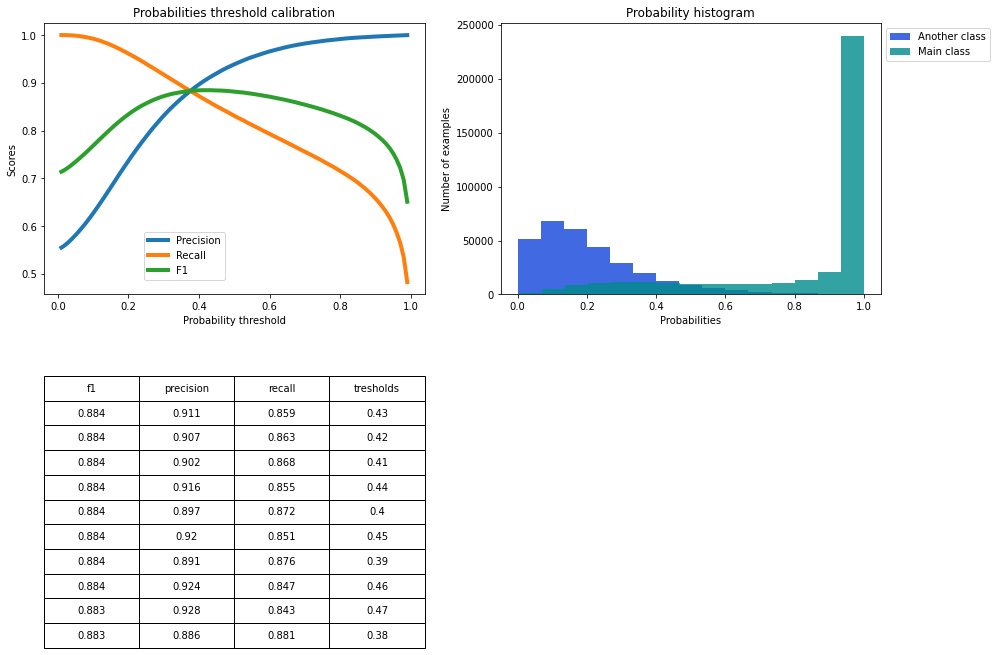

In [38]:
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(train_preds[:, 1], y_train['target'].values)

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87    310686
         1.0       0.91      0.86      0.88    383539

    accuracy                           0.88    694225
   macro avg       0.87      0.88      0.88    694225
weighted avg       0.88      0.88      0.88    694225



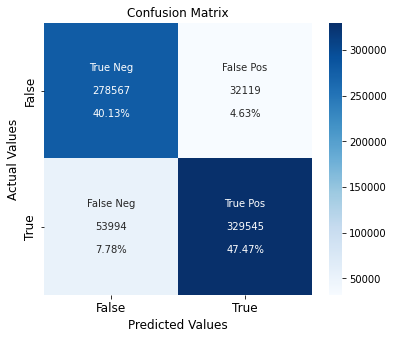

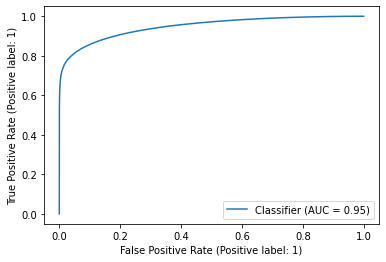

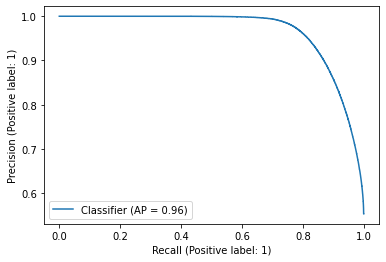

In [39]:
evaluate_preds(train_preds[:, 1], y_train['target'].values, tresholds)

#Тест ранжирования

In [40]:
# взяли пользователей из трейна для ранжирования
df_match_candidates_test = pd.DataFrame(data_val_ranker[USER_COL].unique())
df_match_candidates_test.columns = [USER_COL]

In [41]:
# собираем кандитатов с первого этапа (matcher)
N_PREDICT = 50

df_match_candidates_ALS = calc_get_own(df_match_candidates_test.copy(), model_ALS.get_own_recommendations, 'candidates', N_PREDICT)

df_match_candidates_LightFM = df_match_candidates_test.copy()
model_LightFM_predict_result['warp'] = model_LightFM_predict_result['warp'].apply(lambda x: x[:N_PREDICT])
df_match_candidates_LightFM = df_match_candidates_LightFM.merge(model_LightFM_predict_result, on='user_id', how='inner')
df_match_candidates_LightFM.rename(columns={'warp' : 'candidates'}, inplace=True)

# преобразуем данные
df_items = df_match_candidates_ALS.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates_ALS = df_match_candidates_ALS.drop('candidates', axis=1).join(df_items)

df_items = df_match_candidates_LightFM.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates_LightFM = df_match_candidates_LightFM.drop('candidates', axis=1).join(df_items)
df_match_candidates_LightFM['item_id'] = df_match_candidates_LightFM['item_id'].astype(int)

#объединим и удалим дубликаты
df_match_candidates_test = df_match_candidates_ALS.append(df_match_candidates_LightFM, ignore_index=True).drop_duplicates()

In [42]:
print_stats_data(df_match_candidates_test, 'match_candidates')

match_candidates
Shape: (164592, 2) Users: 1991 Items: 1491



In [43]:
df_ranker_test = data_val_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_test['target'] = 1  # тут только покупки

df_ranker_test = df_match_candidates_test.merge(df_ranker_test, on=[USER_COL, ITEM_COL], how='left')
# чистим дубликаты
df_ranker_test = df_ranker_test.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_test['target'].fillna(0, inplace= True)

In [44]:
df_ranker_test = preprocessor.transform(df_ranker_test, item_features)
df_ranker_test.target.value_counts()

0.0    147572
1.0     17020
Name: target, dtype: int64

In [45]:
df_ranker_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164592 entries, 0 to 164591
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               164592 non-null  int64   
 1   item_id               164592 non-null  int64   
 2   target                164592 non-null  float64 
 3   manufacturer          164592 non-null  int64   
 4   department            164592 non-null  category
 5   brand                 164592 non-null  category
 6   commodity_desc        164592 non-null  category
 7   sub_commodity_desc    164592 non-null  category
 8   curr_size_of_product  164592 non-null  category
 9   price                 164592 non-null  float64 
 10  average_check         164592 non-null  float64 
 11  naverage_purchases    164592 non-null  float64 
 12  purchases_group       164592 non-null  float64 
 13  commodity_item        164592 non-null  int64   
 14  brand_item            164592 non-nul

In [46]:
X_test = df_ranker_test.drop('target', axis=1)
y_test = df_ranker_test[['target']]

In [47]:
test = Pool(
    data=X_test,
    label=y_test,
    cat_features=col
)

train_preds = model_CatBoost.predict_proba(test)

In [48]:
df_ranker_predict = df_ranker_test.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:, 1]
ACTUAL_COL = 'actual'

result_eval_ranker = df_ranker_predict.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

TOPK_PRECISION = 5

result_eval_ranker['reranked_test'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id, df_ranker_predict, TOPK_PRECISION))

In [49]:
result_eval_ranker.head(5)

,user_id,actual,reranked_test
0,1,"[940947, 1075074, 934369, 9527290, 1043064, 55...","[1043064, 1115576, 995478, 977545, 1022053]"
1,3,"[1092937, 998206, 885697, 13842214, 964594, 92...","[7167218, 7167249, 6463658, 9526563, 9527158]"
2,5,"[1009449, 1050851, 929018, 1123022, 1126899, 9...","[952254, 7139529, 1022053, 836445, 830887]"
3,6,"[1119051, 8203834, 895268, 1063207, 1037863, 8...","[1040935, 1098844, 998444, 945662, 1009449]"
4,7,"[1122358, 6944571, 828867, 6602729, 1022003, 8...","[5591154, 9913338, 10121610, 6034964, 822346]"


In [50]:
pd.DataFrame(sorted(calc_precision(result_eval_ranker, TOP_PRECISION), key=lambda x: x[1],reverse=True), columns=['Name', 'Score'])

,Name,Score
0,actual,1.0
1,reranked_test,1.0


#Тест по файлу retail_test1.csv

In [51]:
data_test = pd.read_csv('./data/retail_test1.csv')

# взяли пользователей из трейна для ранжирования
df_match_candidates_test = pd.DataFrame(data_test[USER_COL].unique())
df_match_candidates_test.columns = [USER_COL]

In [52]:
# собираем кандитатов с первого этапа (matcher)
N_PREDICT = 50

df_match_candidates_ALS = calc_get_own(df_match_candidates_test.copy(), model_ALS.get_own_recommendations, 'candidates', N_PREDICT)

df_match_candidates_LightFM = df_match_candidates_test.copy()
model_LightFM_predict_result['warp'] = model_LightFM_predict_result['warp'].apply(lambda x: x[:N_PREDICT])
df_match_candidates_LightFM = df_match_candidates_LightFM.merge(model_LightFM_predict_result, on='user_id', how='inner')
df_match_candidates_LightFM.rename(columns={'warp' : 'candidates'}, inplace=True)

# преобразуем данные
df_items = df_match_candidates_ALS.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates_ALS = df_match_candidates_ALS.drop('candidates', axis=1).join(df_items)

df_items = df_match_candidates_LightFM.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates_LightFM = df_match_candidates_LightFM.drop('candidates', axis=1).join(df_items)
df_match_candidates_LightFM['item_id'] = df_match_candidates_LightFM['item_id'].astype(int)

#объединим и удалим дубликаты
df_match_candidates_test = df_match_candidates_ALS.append(df_match_candidates_LightFM, ignore_index=True).drop_duplicates()

In [53]:
print_stats_data(df_match_candidates_test, 'match_candidates')

match_candidates
Shape: (157379, 2) Users: 1885 Items: 1489



In [54]:
df_ranker_test = data_test[[USER_COL, ITEM_COL]].copy()
df_ranker_test['target'] = 1  # тут только покупки

df_ranker_test = df_match_candidates_test.merge(df_ranker_test, on=[USER_COL, ITEM_COL], how='left')
# чистим дубликаты
df_ranker_test = df_ranker_test.drop_duplicates(subset=[USER_COL, ITEM_COL])
df_ranker_test['target'].fillna(0, inplace= True)

In [55]:
df_ranker_test = preprocessor.transform(df_ranker_test, item_features)
df_ranker_test.target.value_counts()

0.0    137556
1.0     19823
Name: target, dtype: int64

In [56]:
df_ranker_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157379 entries, 0 to 157378
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               157379 non-null  int64   
 1   item_id               157379 non-null  int64   
 2   target                157379 non-null  float64 
 3   manufacturer          157379 non-null  int64   
 4   department            157379 non-null  category
 5   brand                 157379 non-null  category
 6   commodity_desc        157379 non-null  category
 7   sub_commodity_desc    157379 non-null  category
 8   curr_size_of_product  157379 non-null  category
 9   price                 157379 non-null  float64 
 10  average_check         157379 non-null  float64 
 11  naverage_purchases    157379 non-null  float64 
 12  purchases_group       157379 non-null  float64 
 13  commodity_item        157379 non-null  int64   
 14  brand_item            157379 non-nul

In [57]:
X_test = df_ranker_test.drop('target', axis=1)
y_test = df_ranker_test[['target']]

In [58]:
test = Pool(
    data=X_test,
    label=y_test,
    cat_features=col
)

train_preds = model_CatBoost.predict_proba(test)

In [59]:
df_ranker_predict = df_ranker_test.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:, 1]
ACTUAL_COL = 'actual'

result_eval_ranker = df_ranker_predict.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

TOPK_PRECISION = 5

result_eval_ranker['reranked_test_2'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id, df_ranker_predict, TOPK_PRECISION))

In [60]:
result_eval_ranker.head(5)

,user_id,actual,reranked_test_2
0,1,"[940947, 1075074, 934369, 9527290, 1043064, 55...","[1043064, 1115576, 995478, 977545, 1022053]"
1,2,"[1075368, 1040807, 940947, 989101, 1108168, 80...","[958137, 1110244, 900610, 900072, 826144]"
2,3,"[1092937, 998206, 885697, 13842214, 964594, 92...","[7167218, 7167249, 6463658, 9526563, 9527158]"
3,6,"[1119051, 8203834, 895268, 1063207, 1037863, 8...","[1040935, 1098844, 998444, 945662, 1009449]"
4,7,"[1122358, 6944571, 828867, 6602729, 1022003, 8...","[5591154, 9913338, 10121610, 6034964, 822346]"


In [63]:
result_eval_ranker.to_csv('./data/result_eval_ranker.csv', index=False)

In [64]:
pd.DataFrame(sorted(calc_precision(result_eval_ranker, TOP_PRECISION), key=lambda x: x[1],reverse=True), columns=['Name', 'Score'])

,Name,Score
0,actual,1.0
1,reranked_test_2,1.0


# Сохраним все модели

In [66]:
import dill

with open('./models/model_ALS.dill', 'wb') as f:
    dill.dump(model_ALS, f)

with open('./models/model_LightFM.dill', 'wb') as f:
    dill.dump(model_LightFM, f)

with open('./models/model_CatBoost.dill', 'wb') as f:
    dill.dump(model_CatBoost, f)